# Plot effects on the brain
Notebook for making brain plots of lead common and rare variants using nilearn.

Input:
- Common variants: betas + zmat from MOSTest
- Rare variants: betas, SE, P-values from regenie

### Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import h5py
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
from nilearn import plotting, image
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

### Plotting function

In [2]:
def load_column_names_first_line(fn):
    return [str(x) for x in open( fn ).read().split('\n')[0].split("\t") ]

def load_column_names(fn):
    return [str(x) for x in open( fn ).read().split('\n')[:-1] ] 

def get_edge_names(list_names):
    """
    Returns edge combinations for edges
    """
    df_names=pd.DataFrame(index=list_names, columns=list_names)
    for i in range(len(list_names)):
        for j in range(len(list_names)):
            df_names.iloc[i, j] = list_names[i]+"*"+list_names[j]
            
    #heritable = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt") + load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
    #heritable = ["sent_edges_"+x for x in heritable]
    
    return [x for x in list(df_names.to_numpy()[np.triu_indices(len(list_names), k=1)].flatten()) if x in heritable]


def get_idx(cat):
    """
    Returns indices for category
    """
    sent_core_l_ind = [2, 30, 32, 40, 56, 98, 102, 146, 148, 166, 168, 170, 172, 174, 182, 184, 222, 224]
    sent_core_r_ind = [3, 31, 33, 41, 57, 99, 103, 147, 149, 167, 169, 171, 173, 175, 183, 185, 223, 225]
    sent_core_bi_ind = sorted(sent_core_l_ind + sent_core_r_ind)
    
    if cat == "edges":
        return sent_core_bi_ind
    elif cat == "edges_HD":
        return sent_core_l_ind
    
    
def set_up_coordinates(cat):
    """
    get coordinates for plot
    """
    #set up atlas + coordinates
    aicha_atlas = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/multilateral/FuncNet_AICHA/segs/AICHA.nii"
    aicha_img = image.load_img(aicha_atlas)
    aicha_coords = plotting.find_parcellation_cut_coords(aicha_img)
    
    #indices
    idx = get_idx(cat)

    #get coordinates and names
    return aicha_coords[idx, :]

def get_names_aicha(cat):
    """
    Return node names
    """
    aicha_test = "/data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/AICHA/1000099/AICHA_timeseries_NO_GSR_cormat.txt"
    aicha2 = pd.read_csv(aicha_test, sep=";", index_col=0)
    
    idx = get_idx(cat)
    
    if cat == "edges":
        return list(aicha2.columns[idx]) #[x for x in list(aicha2.columns[idx]) if x in heritable]
    elif cat == "edges_HD":
        return list(x[:-2] for x in aicha2.columns[idx]) #[x for x in list(aicha2.columns[idx]) if x in heritable]


def make_nice_mat(input_data, cat, var_name):
    """
    put data from column into right spot in matrix
    """
    #get indices
    ind_names = get_names_aicha(cat)
        
    #set up dataframe
    df_out = pd.DataFrame(index=ind_names, columns=ind_names)
    df_out.iloc[np.diag_indices(len(ind_names)), np.diag_indices(len(ind_names))] = 0
    
    #put data in right place
    for x in list(input_data.columns):
        nodes = x.split("*", 1)
        df_out.loc[nodes[0], nodes[1]] = input_data.loc[var_name, x]
        df_out.loc[nodes[1], nodes[0]] = input_data.loc[var_name, x]
    
    return df_out
        
    
def plot_results_brain_betas(betas, pvals, cat, snp, title, alpha=None, ax=None, out=None, rare=False):
    """
    Main function:
    - loads data
    - significance testing
    - plot using nilearn
    """
    #get correlation values
    beta_mat = make_nice_mat(betas, cat, snp)
    
    if alpha:
        p_mat = make_nice_mat(pvals, cat, snp)
        beta_mat = beta_mat[p_mat < alpha]
    
    #plot
    if np.abs(beta_mat.sum().sum()) < 0.0001:
        plotting.plot_markers([1]*len(beta_mat),
                              set_up_coordinates(cat), 
                              node_cmap="binary",
                              node_size=30,
                              alpha=0.8, 
                              display_mode='lyrz',
                              title=title, 
                              colorbar=False,
                              axes=ax)
        
    else:
        if rare:
            colors = ["whitesmoke", "indianred"]
            cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
            
            plotting.plot_connectome(beta_mat.to_numpy(dtype=float),
                             set_up_coordinates(cat),
                             title=title,
                             edge_cmap=cmap1,
                             edge_vmin=0,
                             edge_vmax=np.max(np.max(beta_mat)),
                             node_color="dimgrey",
                             node_size=30,
                             display_mode="lyrz",
                             colorbar=True,
                             alpha=0.8,
                             axes=ax)
                             #output_file=out)    
        else:
            colors = ["mediumblue", "cornflowerblue", "lightgrey", "whitesmoke", "lightgrey", "lightcoral", "indianred"]
            cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
            plotting.plot_connectome(beta_mat.to_numpy(dtype=float),
                             set_up_coordinates(cat),
                             title=title,
                             edge_cmap=cmap1,
                             node_color="dimgrey",
                             node_size=30,
                             display_mode="lyrz",
                             colorbar=True,
                             alpha=0.8,
                             axes=ax)
                             #output_file=out)    



### Data loader common variants

In [13]:
def add_row(df, new_data, column_names, index_name, np_array=True):
    if np_array:
        df_new = pd.DataFrame(data=new_data.reshape((1, len(column_names))), columns=column_names, index=[index_name])
    else:
        df_new = pd.DataFrame.from_dict(new_data)
    return pd.concat([df, df_new], axis=0)
        
def get_snp(chr_no, snp_id):
    """
    """
    if chr_no == 23:
        bim_fn = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/in/mostest_geno_in_cX.bim"
    else:
        bim_fn = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/in/mostest_geno_in_c{}.bim".format(chr_no)
    
    bim = pd.read_csv(bim_fn, sep='\t', header=None, names='CHR SNP GP BP A1 A2'.split())
    snp = bim.SNP.values == snp_id
    return snp, bim.loc[bim.SNP.values == snp_id, :].to_dict()

def get_file_name_mat(cat, chr_no):
    if chr_no == 23:
        return "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/out/sent_edges/edges_chrX_zmat.mat"
    if cat == "edges":
        return "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/out/sent_edges/edges_chr{}_zmat.mat".format(chr_no)
    if cat == "edges_HD":
        return "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/out/sent_edges_asym/edges_asym_chr{}_zmat.mat".format(chr_no)

def get_betas_pvals(fname, snps):
    with h5py.File(fname, 'r') as h5file:
        beta_orig = np.array(h5file['beta_orig'])
        zmat_orig=np.array(h5file['zmat_orig'])
        pval_orig = stats.norm.sf(np.abs(zmat_orig))*2.0

        betas_snp = beta_orig[:, snps]
        pval_snp = pval_orig[:, snps]
    
        return betas_snp, pval_snp
    
def data_munger_MOSTEST_betas(snp_df, col_names, cat):
    """
    Load underlying beta's from MOSTEST analysis
    """
    
    beta_df = pd.DataFrame(columns=col_names)
    pval_df = pd.DataFrame(columns=col_names)
    snp_info_df = pd.DataFrame(columns='CHR SNP GP BP A1 A2'.split())
    
    for snp_no in snp_df.index.values:
        snp, snp_all = get_snp(snp_df.chr_no[snp_no], snp_df.ID[snp_no])
        
        print(snp_df.ID[snp_no])
    
        betas_snp, pval_snp = get_betas_pvals(fname=get_file_name_mat(cat, snp_df.chr_no[snp_no]),
                                               snps=snp)
        
        beta_df = add_row(df = beta_df,
                          new_data = betas_snp,
                          column_names = col_names,
                          index_name = snp_df.ID[snp_no])
        
        pval_df = add_row(df = pval_df,
                          new_data = pval_snp,
                          column_names = col_names,
                          index_name = snp_df.ID[snp_no])
        
        snp_info_df = add_row(df = snp_info_df,
                              new_data = snp_all,
                              column_names = 'CHR SNP GP BP A1 A2'.split(),
                              index_name = snp_df.ID[snp_no],
                              np_array=False)
    
    return beta_df, pval_df, snp_info_df

### Data loader rare variants

In [4]:
#set significance testing
no_phenos = 629+103
no_variants_included = 12
alpha = 0.05/(no_phenos*no_variants_included)

#set figure path
plot_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results"

## Common variant plotting
Input:
- betas from MOSTEST
- dataframe with lead SNPs

Process:
- load betas and z-mat
- derive P from zmat
- plot using nilearn

Output:
- connectivity plot

#### Fig 1c. Language network

In [5]:
common_top_lang = pd.DataFrame.from_dict({"chr_no":[3,3,10], "ID":["rs35124509", "rs2279829", "rs2274224"]})
col_names_lang = load_column_names_first_line("/data/clusterfs/lag/users/jitame/SENT_CORE/pheno/sent_edges_N29681_resid_mostest.txt")
beta_lang, p_lang, snp_lang = data_munger_MOSTEST_betas(common_top_lang, col_names=col_names_lang, cat="edges")

In [14]:
common_all_lang = pd.DataFrame.from_dict({"chr_no":[2,3,3,3,3,4,10,10,11,14,17,17,18,23], "ID":["rs2717066", "rs17273020", "rs35124509", "rs143322006", "rs2279829", "rs2131466", "rs2274224", "rs4469802", "rs10897597", "rs468213", "rs4924967", "rs2732687", "rs7234875", "rs2360257"]})
#common_all_lang = pd.DataFrame.from_dict({"chr_no":[2,3,3,3,3,4,10], "ID":["rs2717066", "rs17273020", "rs35124509", "rs143322006", "rs2279829", "rs2131466", "rs2274224"]})
col_names_lang = load_column_names_first_line("/data/clusterfs/lag/users/jitame/SENT_CORE/pheno/sent_edges_N29681_resid_mostest.txt")
beta_lang, p_lang, snp_lang = data_munger_MOSTEST_betas(common_all_lang, col_names=col_names_lang, cat="edges")

rs2717066
rs17273020
rs35124509
rs143322006
rs2279829
rs2131466
rs2274224
rs4469802
rs10897597
rs468213
rs4924967
rs2732687
rs7234875
rs2360257


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/out/sent_edges/edges_chr23_zmat.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
common_all_lang_2 = pd.DataFrame.from_dict({"chr_no":[10,11,14,17,17,18,23], "ID":["rs2717066", "rs17273020", "rs35124509", "rs143322006", "rs2279829", "rs2131466", "rs2274224", "rs4469802", "rs10897597", "rs468213", "rs4924967", "rs2732687", "rs7234875", "rs2360257"]})
col_names_lang = load_column_names_first_line("/data/clusterfs/lag/users/jitame/SENT_CORE/pheno/sent_edges_N29681_resid_mostest.txt")
beta_lang_2, p_lang_2, snp_lang_2 = data_munger_MOSTEST_betas(common_all_lang_2, col_names=col_names_lang, cat="edges")

In [ ]:
fig_args = {"figsize":(18,24),"dpi":300}

fig, ax = plt.subplots(len(beta_lang), 2, gridspec_kw={'height_ratios': [1]*len(beta_lang)}, **fig_args)

for x, snp in enumerate(beta_lang.index.values):
    if x < 7:
        plot_results_brain_betas(betas=beta_lang,
                             pvals=p_lang,
                             cat="edges",
                             ax=ax[x, 0],
                             title="{0} (chr{1}_{2}_{3}:{4})".format(snp,
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "CHR"].to_string(index=False),
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "BP"].to_string(index=False),
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "A1"].to_string(index=False),
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "A2"].to_string(index=False)),
                             snp=snp)
    else:
        i=x-7
        plot_results_brain_betas(betas=beta_lang,
                             pvals=p_lang,
                             cat="edges",
                             ax=ax[i, 1],
                             title="{0} (chr{1}_{2}_{3}:{4})".format(snp,
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "CHR"].to_string(index=False),
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "BP"].to_string(index=False),
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "A1"].to_string(index=False),
                                                                   snp_lang.loc[snp_lang.SNP.values == snp, "A2"].to_string(index=False)),
                             snp=snp)

fig.suptitle("Betas common lead variants language network", fontsize=24)
plt.savefig(fname=os.path.join(plot_path, "lang_net_common_vars_eff_size_suppl.png"), bbox_inches="tight")

#### Fig 2c. Asymmetries

In [7]:
common_top_asym = pd.DataFrame.from_dict({"chr_no":[3,3,3], "ID":["rs7635916", "rs2279829", "rs13321297"]})
col_names_asym = load_column_names_first_line("/data/clusterfs/lag/users/jitame/SENT_CORE/pheno/sent_edges_asym_N29681_resid_mostest.txt")
beta_asym, p_asym, snp_asym = data_munger_MOSTEST_betas(common_top_asym, col_names=col_names_asym, cat="edges_HD")

In [ ]:
fig_args = {"figsize":(8,10),"dpi":300}

fig, ax = plt.subplots(len(beta_lang), 1, gridspec_kw={'height_ratios': [1]*len(beta_lang)}, **fig_args)

for x, snp in enumerate(beta_asym.index.values):
    plot_results_brain_betas(betas=beta_asym,
                             pvals=p_asym,
                             cat="edges_HD",
                             ax=ax[x],
                             snp=snp,
                             title="{0} (chr{1}_{2}_{3}:{4})".format(snp,
                                                                     snp_asym.loc[snp_asym.SNP.values == snp, "CHR"].to_string(index=False),
                                                                     snp_asym.loc[snp_asym.SNP.values == snp, "BP"].to_string(index=False),
                                                                     snp_asym.loc[snp_asym.SNP.values == snp, "A1"].to_string(index=False),
                                                                     snp_asym.loc[snp_asym.SNP.values == snp, "A2"].to_string(index=False)))

ax[0].text(0, 1.13, "F. Betas common lead variants hemispheric differences", fontsize=16)
plt.savefig(fname=os.path.join(plot_path, "asym_common_vars_eff_size.png"), bbox_inches="tight")

## Rare variant plotting
Input:
- betas, P-vals from regenie

Process:
- load betas and p-values
- plot using nilearn

Output:
- connectivity plot

In [9]:
rare_genes = pd.read_csv(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "all_exome_results.csv"), engine="pyarrow")

In [10]:
def add_gene_names(data):
    """
    ADDS GENE NAME BASED ON ENSEMBL ID
    """
    
    from pyensembl import EnsemblRelease
    data_ens = EnsemblRelease(108)
    
    #parse gene ids and names
    data["gene_id"] = [id_name.split(".")[0] for id_name in data["ID"]]
    data["gene_name"] = [get_gene_name(gene_id, data_ens) for gene_id in data["gene_id"]]
    
    return data

def get_gene_name(gene_id, data_ens):
    """
    """
    try:
        gene_name = data_ens.gene_name_of_gene_id(gene_id)
    except ValueError:
        gene_name = ""
    return gene_name

In [11]:
rare_genes = add_gene_names(rare_genes)

In [12]:
data_skato_strict = rare_genes[np.array([rare_genes["TEST"] == "ADD-SKATO", rare_genes["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(rare_genes), 1))]
data_skato_broad = rare_genes[np.array([rare_genes["TEST"] == "ADD-SKATO", rare_genes["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(rare_genes), 1))]

In [13]:
alpha_burden_genebass = -np.log10(6.7 * 10 ** -7)
alpha_skato_genebass = -np.log10(2.5 * 10 ** -7) #from genebass paper: https://www.cell.com/cell-genomics/fulltext/S2666-979X(22)00110-0#secsectitle0080



In [14]:
heritable_lang = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt")
heritable_lang = ["LOGP_sent_edges_"+x for x in heritable_lang]
lang_strict_sig = data_skato_strict[data_skato_strict["MINP_edges"] > alpha_skato_genebass].set_index("gene_name")
lang_broad_sig = data_skato_broad[data_skato_broad["MINP_edges"] > alpha_skato_genebass].set_index("gene_name")

p_df_broad = lang_broad_sig[heritable_lang]
p_df_broad.columns=[x[16:] for x in p_df_broad.columns]

/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=

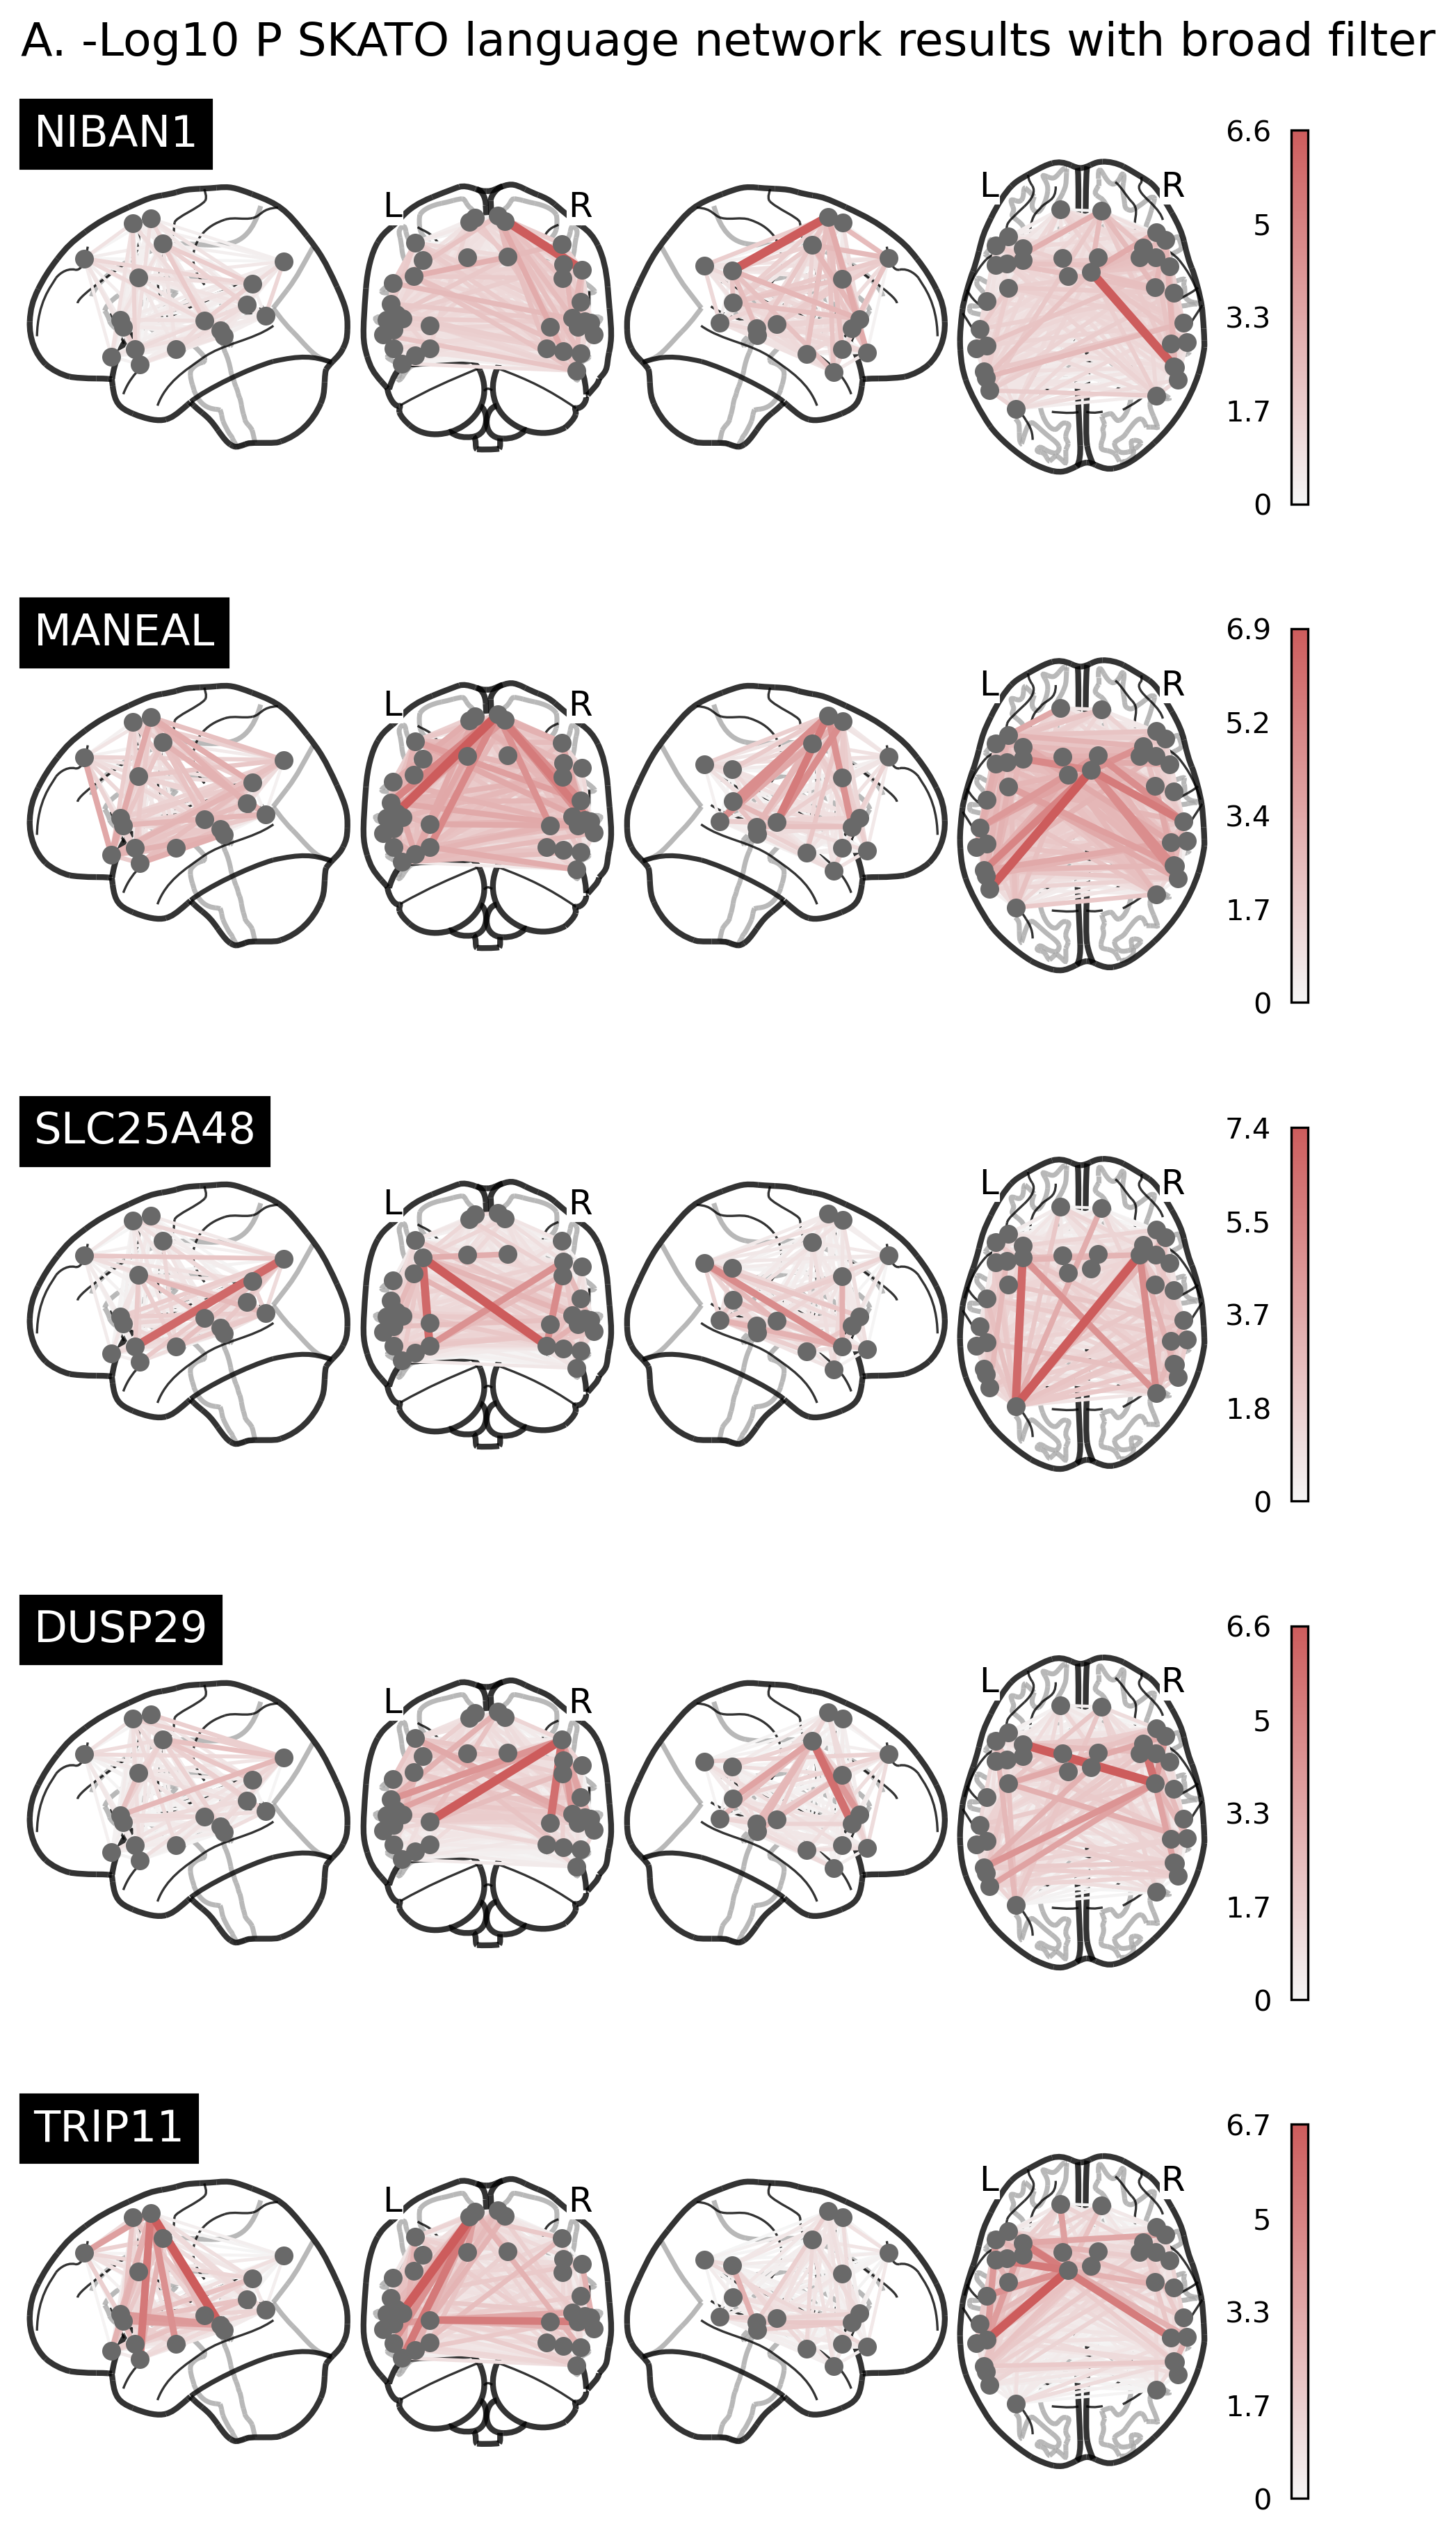

In [15]:
fig_args = {"figsize":(8,15),"dpi":300}

fig, ax = plt.subplots(len(p_df_broad), 1, gridspec_kw={'height_ratios': [1]*len(p_df_broad)}, **fig_args)

for x, gene in enumerate(p_df_broad.index.values):
    plot_results_brain_betas(betas=p_df_broad,
                             pvals=p_df_broad,
                             cat="edges",
                             ax=ax[x],
                             title=gene,
                             snp=gene,
                            rare=True)

ax[0].text(0, 1.13, "A. -Log10 P SKATO language network results with broad filter", fontsize=16)
plt.savefig(fname=os.path.join(plot_path, "lang_net_rare_broad_skato.png"), bbox_inches="tight")

In [16]:
heritable_asym = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
heritable_asym = ["LOGP_sent_edges_"+x for x in heritable_asym]
asym_strict_sig = data_skato_strict[data_skato_strict["MINP_HDs"] > alpha_skato_genebass].set_index("gene_name")
asym_broad_sig = data_skato_broad[data_skato_broad["MINP_HDs"] > alpha_skato_genebass].set_index("gene_name")

p_df_strict = asym_strict_sig[heritable_asym]
p_df_strict.columns=[x[16:] for x in p_df_strict.columns]

/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


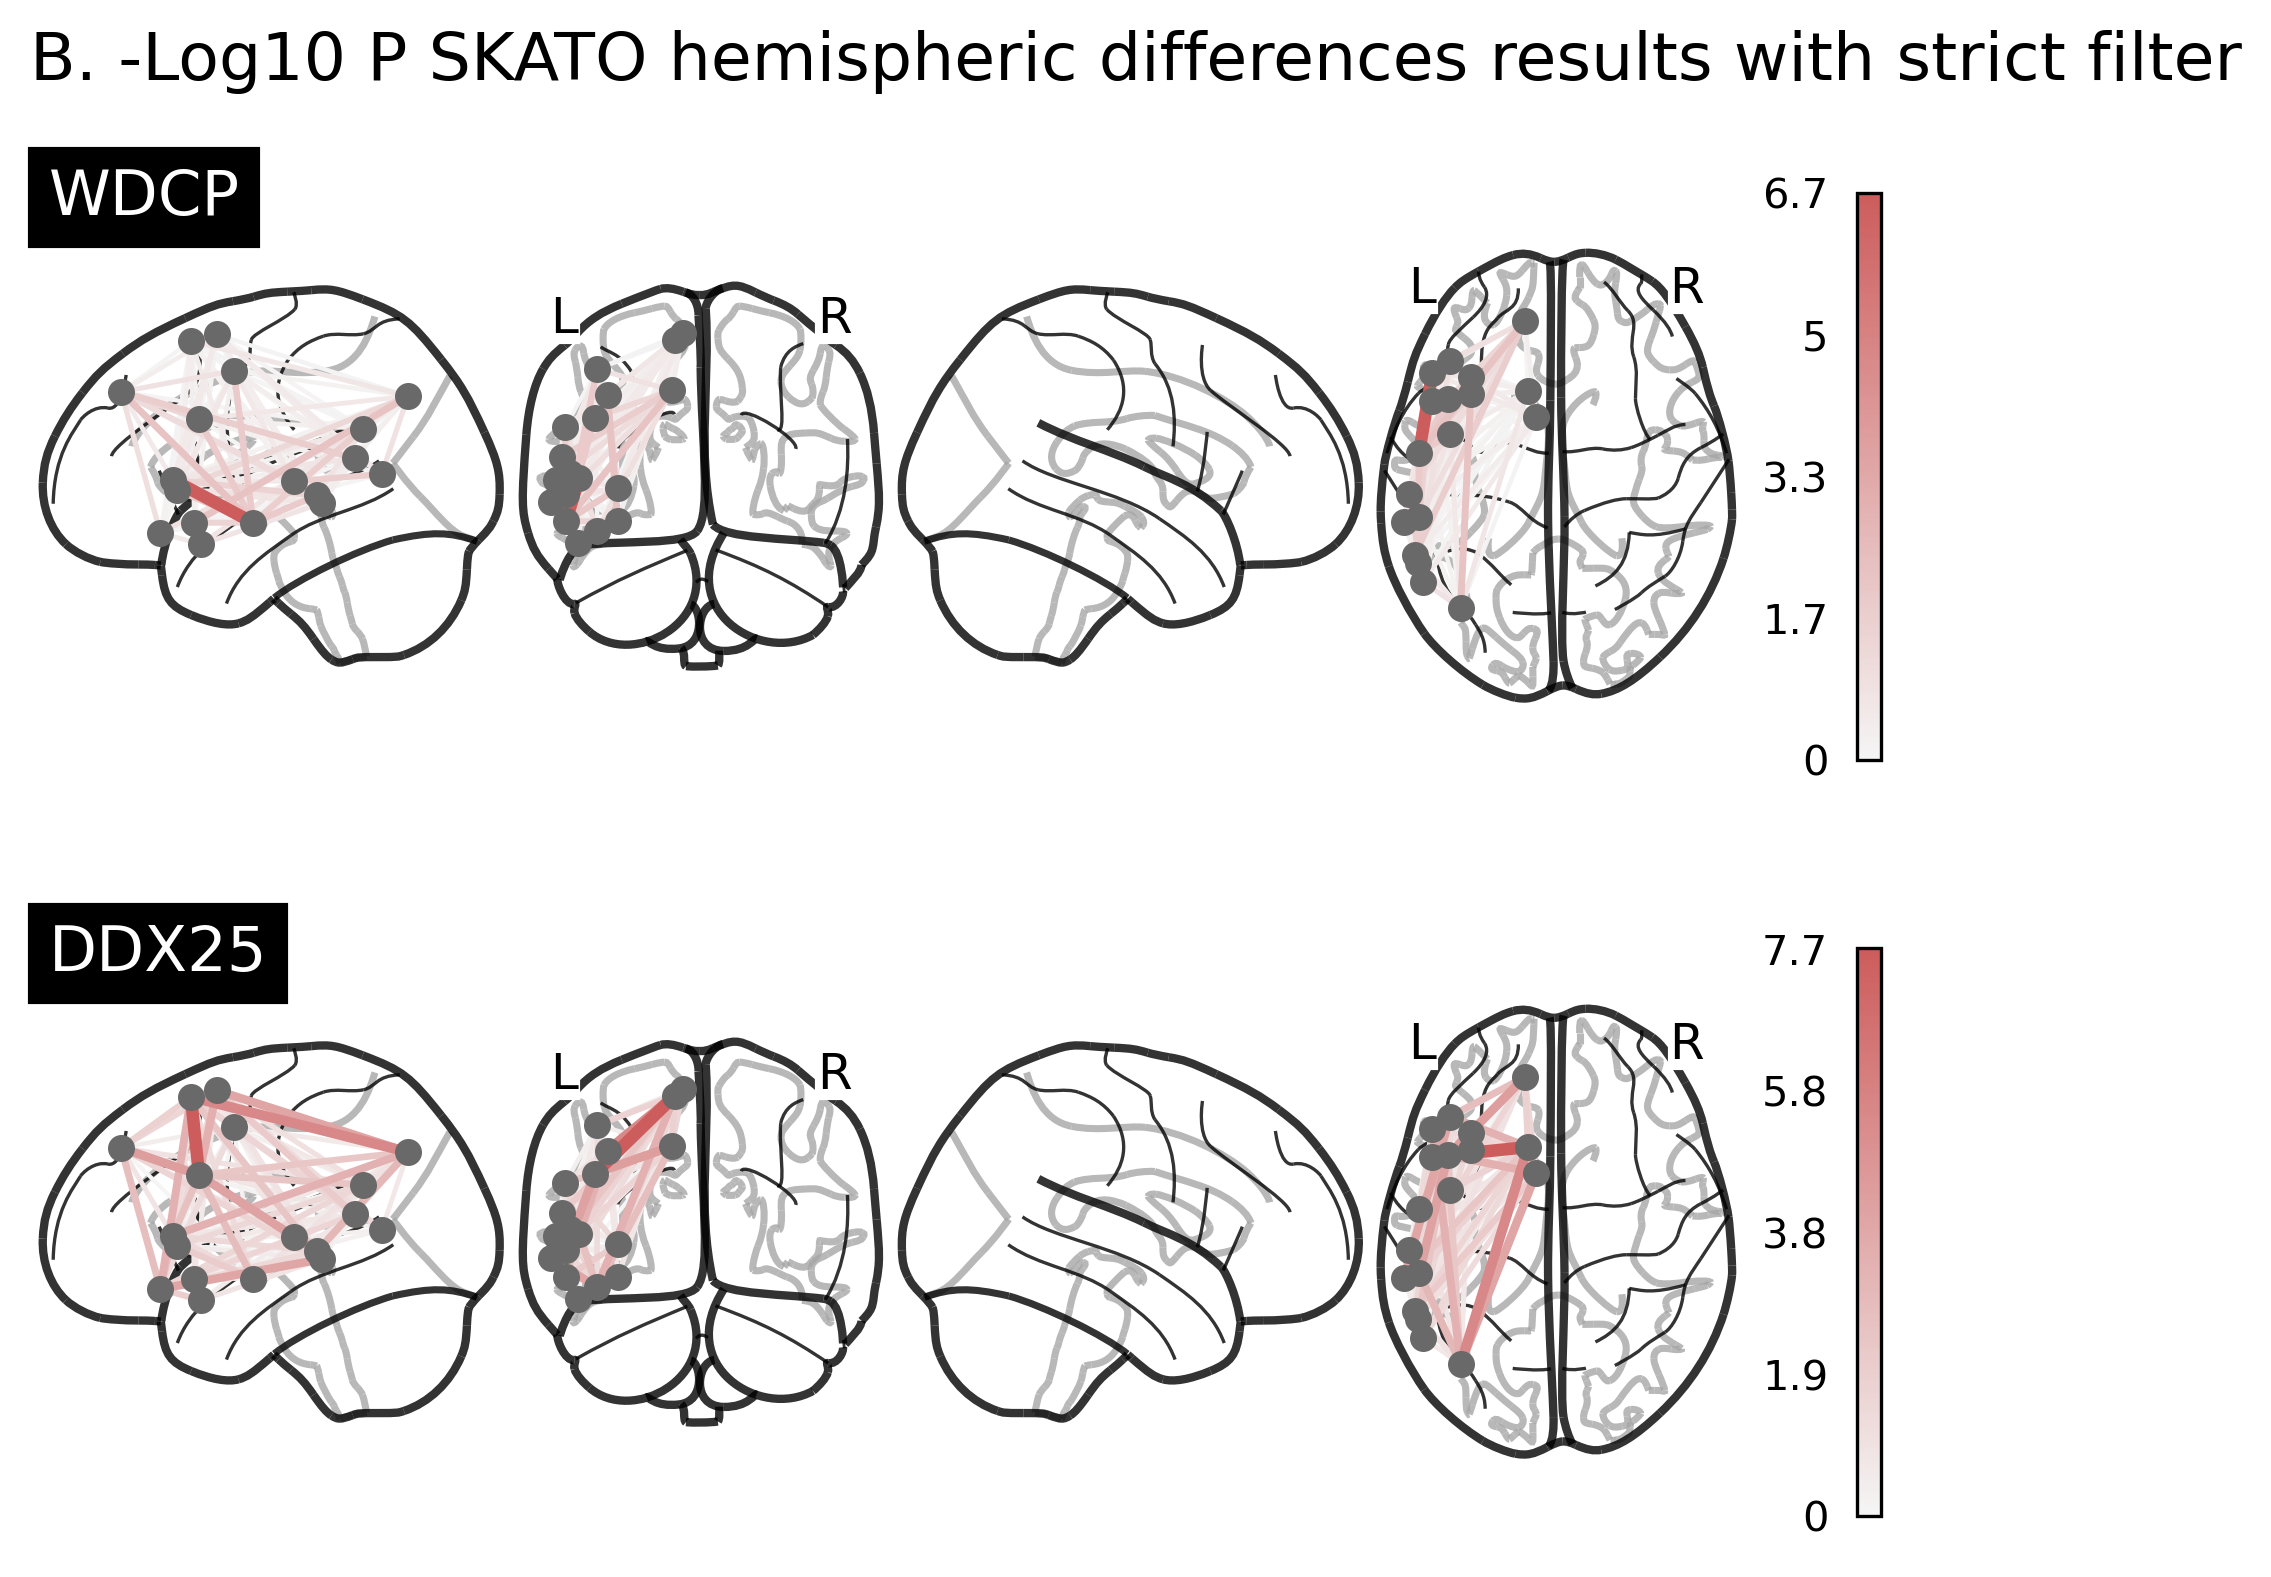

In [17]:
fig_args = {"figsize":(8,6),"dpi":300}

fig, ax = plt.subplots(len(p_df_strict), 1, gridspec_kw={'height_ratios': [1]*len(p_df_strict)}, **fig_args)

for x, gene in enumerate(p_df_strict.index.values):
    plot_results_brain_betas(betas=p_df_strict,
                             pvals=p_df_strict,
                             cat="edges_HD",
                             ax=ax[x],
                             title=gene,
                             snp=gene,
                             rare=True)

ax[0].text(0, 1.13, "B. -Log10 P SKATO hemispheric differences results with strict filter", fontsize=16)
plt.savefig(fname=os.path.join(plot_path, "asym_rare_strict_logp.png"), bbox_inches="tight")

In [18]:
#find lead genes top

In [19]:
data_burden_strict = rare_genes[np.array([rare_genes["TEST"] == "ADD", rare_genes["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(rare_genes), 1))]
data_burden_broad = rare_genes[np.array([rare_genes["TEST"] == "ADD", rare_genes["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(rare_genes), 1))]

In [20]:
genes=["MANEAL", "DUSP29", "SLC25A48", "TRIP11", "NIBAN1"]

heritable_lang = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt")
heritable_lang = ["BETA_sent_edges_"+x for x in heritable_lang]
lang_burden_broad_sig = data_burden_broad.set_index("gene_name").loc[genes, :]

p_df_broad = lang_burden_broad_sig[heritable_lang]
p_df_broad.columns=[x[16:] for x in p_df_broad.columns]

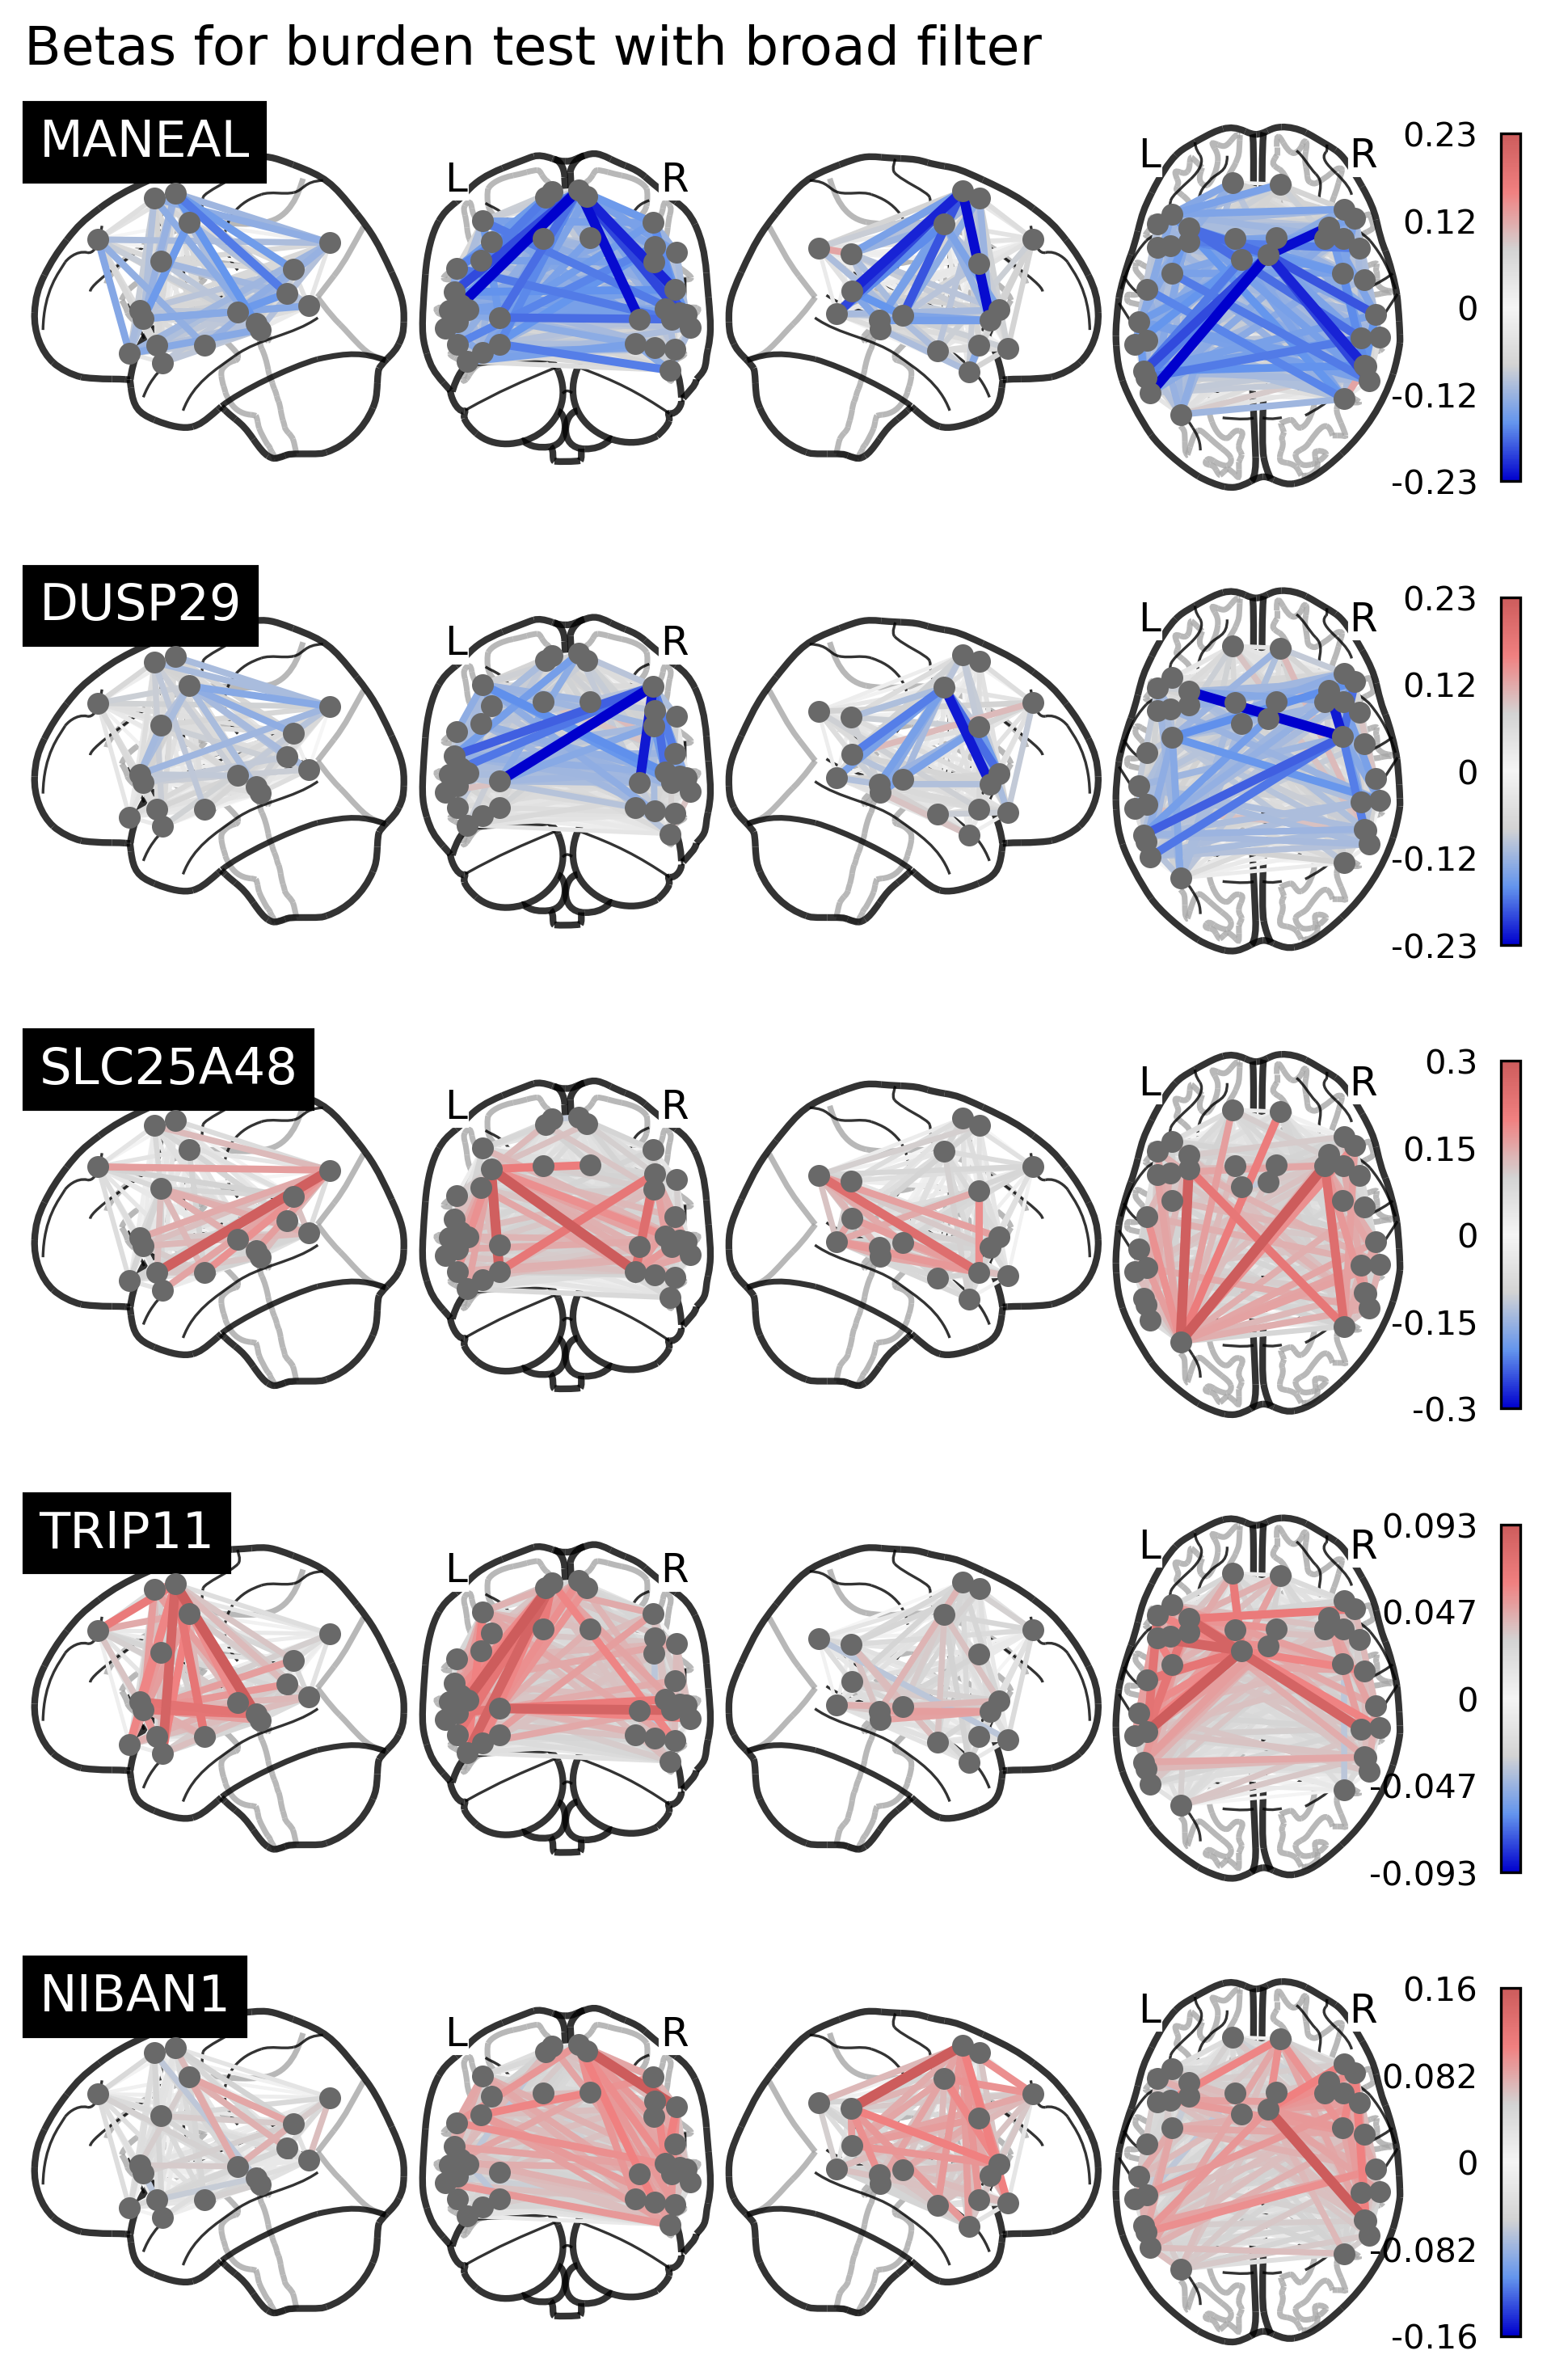

In [21]:
fig_args = {"figsize":(8,12),"dpi":300}

fig, ax = plt.subplots(len(p_df_broad), 1, gridspec_kw={'height_ratios': [1]*len(p_df_broad)}, **fig_args)

for x, gene in enumerate(p_df_broad.index.values):
    plot_results_brain_betas(betas=p_df_broad,
                             pvals=p_df_broad,
                             cat="edges",
                             ax=ax[x],
                             title=gene,
                             snp=gene,
                            rare=False)

ax[0].text(0, 1.13, "Betas for burden test with broad filter", fontsize=16)
plt.savefig(fname=os.path.join(plot_path, "lang_net_rare_broad_burden_beta.png"), bbox_inches="tight")

In [22]:
genes = ["WDCP", "DDX25"]

heritable_asym = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
heritable_asym = ["BETA_sent_edges_"+x for x in heritable_asym]
asym_strict_sig = data_burden_strict.set_index("gene_name").loc[genes, :]

p_df_strict = asym_strict_sig[heritable_asym]
p_df_strict.columns=[x[16:] for x in p_df_strict.columns]

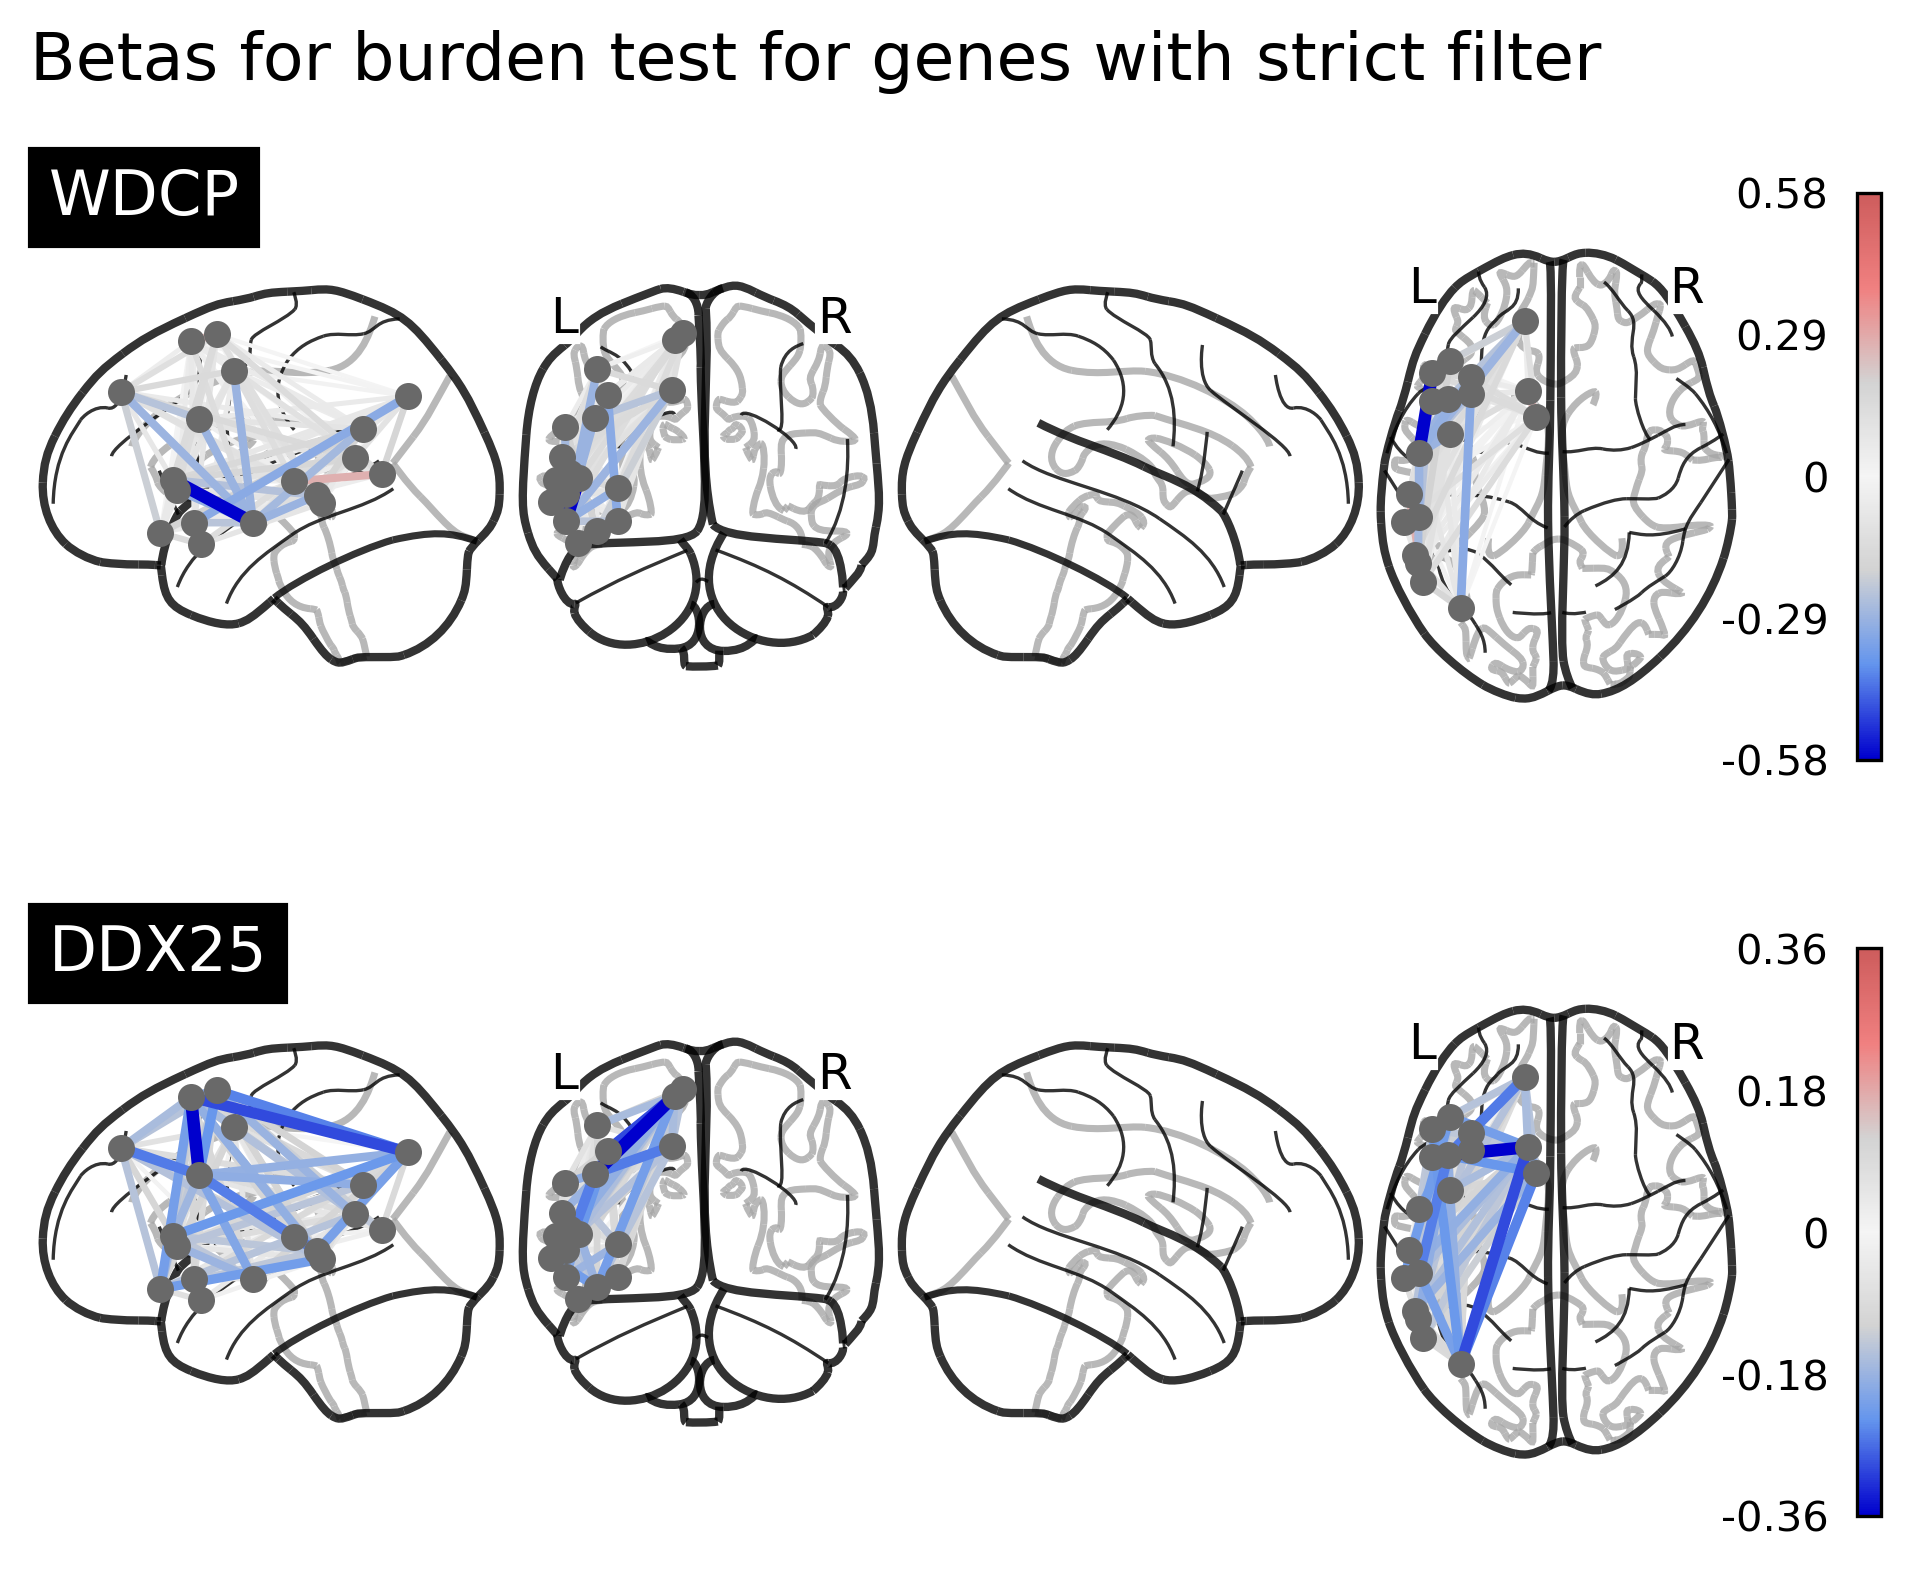

In [23]:
fig_args = {"figsize":(8,6),"dpi":300}

fig, ax = plt.subplots(len(p_df_strict), 1, gridspec_kw={'height_ratios': [1]*len(p_df_strict)}, **fig_args)

for x, gene in enumerate(p_df_strict.index.values):
    plot_results_brain_betas(betas=p_df_strict,
                             pvals=p_df_strict,
                             cat="edges_HD",
                             ax=ax[x],
                             title=gene,
                             snp=gene,
                             rare=False)

ax[0].text(0, 1.13, "Betas for burden test for genes with strict filter", fontsize=16)
plt.savefig(fname=os.path.join(plot_path, "asym_rare_strict_burden.png"), bbox_inches="tight")